In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [114]:
def generate_synthetic_clusters(sample_size, n_clusters, n_dims, spread=0.1, split_evan=True, label_clusters=True, random_state=None):
    """
    Generates synthetic clustered data in a multidimensional space.
    
    Parameters:
    - sample_size (int): Total number of samples to generate across all clusters.
    - n_clusters (int): Number of clusters to create.
    - n_dims (int): Number of dimensions (features) for each data point.
    - spread (float, optional): Standard deviation of each cluster, controlling how dispersed the points are. Default is 0.1.
    - split_evan (bool, optional): If True, distributes samples evenly across clusters. If False, assigns samples randomly. Default is True.
    - label_clusters (bool, optional): If True, includes cluster labels in the output DataFrame. Default is True.
    - random_state (int, optional): Seed for random number generation to ensure reproducibility. Default is None.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the generated data points with `n_dims` features. If `label_clusters` is True, an additional
      'label' column is included representing cluster assignments.
    """
    np.random.seed(random_state)
    
    # Generate random cluster centers within [0, 1] for all dimensions
    centers = np.random.rand(n_clusters, n_dims)

    if split_evan:
        # Generate equal number of samples per cluster
        cluster_size = sample_size // n_clusters
        remainder = sample_size % n_clusters
        samples_per_cluster = [cluster_size] * n_clusters
        # Distribute remainder to the first 'remainder' clusters
        if remainder==1:
            remainder_idx = np.random.choice(n_clusters)
            samples_per_cluster[remainder_idx] += 1
    else:
        # Generate random number of samples per cluster
        split_points = sorted(np.random.choice(range(1, sample_size), n_clusters - 1))
        samples_per_cluster = [split_points[0]] + [split_points[i] - split_points[i - 1] for i in range(1, len(split_points))] + [sample_size - split_points[-1]]
    
    data = []
    labels = []
    for cluster_idx in range(n_clusters):
        # Generate points around the cluster center using normal distribution
        cluster_data = np.random.normal(
            loc=centers[cluster_idx],
            scale=spread,
            size=(samples_per_cluster[cluster_idx], n_dims)
        )
        
        # Clip data to ensure values stay within [0, 1]
        cluster_data = np.clip(cluster_data, 0.0, 1.0)
        
        # Append cluster data and labels
        data.append(cluster_data)
        labels.extend([cluster_idx] * samples_per_cluster[cluster_idx])
    
    # Combine all clusters into single array
    data = np.vstack(data)
    labels = np.array(labels)

    # create a random permutation of the data
    permutation = np.random.permutation(data.shape[0])
    data = data[permutation]
    labels = labels[permutation]

    # create dataframe
    df = pd.DataFrame(data)
    if label_clusters:
        df['label'] = labels
    
    return df

In [116]:
def visualize_clusters(df, label_clusters=True):
    """
    Visualizes the clustered data using a scatterplot.
    If the data has more than 2 dimensions, PCA is applied to reduce it to 2D.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the synthetic cluster data.
    - label_clusters (bool, optional): Whether to color points based on cluster labels. Default is True.
    
    Returns:
    - None: Displays a scatter plot of the clustered data.
    """
    # Extract features (all columns except 'label' if present)
    if label_clusters and 'label' in df.columns:
        features = df.drop(columns=['label'])
        labels = df['label']
    else:
        features = df
        labels = None
    
    if features.shape[1] == 1:
        x_data = features.iloc[:, 0]
        sns.histplot(x=x_data, hue=labels if label_clusters and labels is not None else None, kde=True, bins=20, palette='viridis', alpha=0.6)
        plt.xlabel("Value")
        plt.ylabel("Frequency")

    else:
        if features.shape[1] == 2:
            x_data, y_data = features.iloc[:, 0], features.iloc[:, 1]
        else:
            # Reduce dimensionality if necessary
            pca = PCA(n_components=2)
            features_pca = pca.fit_transform(features)
            x_data, y_data = features_pca[:, 0], features_pca[:, 1]
        
        # Create scatter plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=x_data,
            y=y_data,
            hue=labels if label_clusters and labels is not None else None, 
            palette='viridis', 
            edgecolor='k', 
            alpha=0.7
        )
        plt.xlabel("Component 1" if features.shape[1] > 2 else "Feature 1")
        plt.ylabel("Component 2" if features.shape[1] > 2 else "Feature 2")
        plt.title("Data Visualization (PCA)" if features.shape[1] > 2 else "Data Visualization")
        plt.legend(title="Cluster" if label_clusters and labels is not None else None)
        plt.show()

In [121]:
# Generate 3 clusters in 2D space with 100 points per cluster
df = generate_synthetic_clusters(
    sample_size=100,
    n_clusters=3,
    n_dims=1,
    spread=0.05,
    split_evan=True,
    label_clusters=True,
    random_state=42
)

print(f"Data shape: {df.shape}")
if 'label' in df.columns:
    print(f"size per cluster:\n{df['label'].value_counts().sort_index()}")
print(f"data:\n{df.head()}")

Data shape: (100, 2)
size per cluster:
label
0    34
1    33
2    33
Name: count, dtype: int64
data:
          0  label
0  0.716186      2
1  0.951989      1
2  0.404712      0
3  0.395391      0
4  0.959349      1


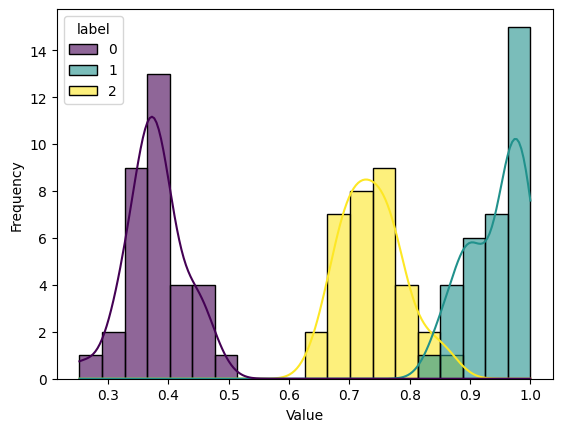

In [122]:
visualize_clusters(df, label_clusters=True)